# Hilbert Huang Transform

In [1]:
from scipy.signal import hilbert,spectrogram
from scipy.sparse import csr_matrix
from PyEMD import EMD,EEMD
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import numpy.matlib

import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path

import scipy
scipy.__version__

'1.5.0'

In [2]:
def invEMD(imfs,res):
    return res + imfs.sum(axis=0)

In [3]:
def ihtrans(x):
    return -1*hilbert(x).imag

In [18]:
def hht(imfs,fs,freq_max=None,freq_min=None,FResol=None,MinThres = np.NINF):
    ''''''
    if ((freq_min is None) & (freq_max is None)):
        FRange = [0,fs/2]
    elif ((freq_min < 0) or (freq_min > freq_max)):
        raise ValueError('Input freq_min error')
    elif freq_max > (fs/2):
        raise ValueError('Input freq_max error')
    else:
        FRange = [freq_min,freq_max]
        
    if FResol is None:
        FResol = (FRange[1]-FRange[0])/100
    elif isinstance(FResol, (int, float)) !=True & (FResol > 0):
        raise ValueError('FResol must be an int or float')
    else:
        pass 
    
    # get size of input object
    n_samples  = imfs.shape[0]-1

    # setup frequency vector
    F = np.linspace(FRange[0], FRange[1], num=int(FRange[1]/FResol)+1)
    print(F.shape)
    # setup time vector
    T = np.linspace(0, (1/fs)*n_samples, num=int((1/fs)*n_samples/(1/fs))+1)
    print(T.shape)
    if imfs.ndim: imfs = np.expand_dims(imfs,axis =0)
        
    for n, imf in enumerate(imfs):
        
        sig = hilbert(imf)
        energy = abs(sig)**2 #.imag .real
        phaseAngle = np.angle(sig)

        #compute instantaneous frequency using phase angle
        omega  = np.gradient(np.unwrap(phaseAngle))

        #convert instantaneous frequency units to Hz
        omega = fs/(2*np.pi)*omega;

        # find out index of the frequency
        omegaIdx = np.floor((omega-F[1])/FResol)+1

        # generate distribution
        if n == 0:
            freqIdx = omegaIdx
            insf = omega
            inse = energy
        else:
            freqIdx = np.vstack((freqIdx,omegaIdx))
            insf = np.vstack((insf,omega))
            inse = np.vstack((inse,energy))
        break

    # filter out points not in the frequency range
    idxKeep = np.where( ( freqIdx>= 0 ) & ( freqIdx <= len(F) ), True, False )
    timeIdx = np.matlib.repmat(range(0,len(T)),imfs.shape[0],1)

    # check if vector or matrix
    if insf.ndim == 1:
        P = csr_matrix((insf[idxKeep], 
                        (freqIdx[idxKeep], timeIdx[0][idxKeep])), 
                       shape=(len(F),len(T) ))
    else:
        P = csr_matrix((insf[idxKeep], 
                        (freqIdx[idxKeep], timeIdx[idxKeep])), 
                       shape=(len(F),len(T) ))
    
    return T,F,P,insf,inse

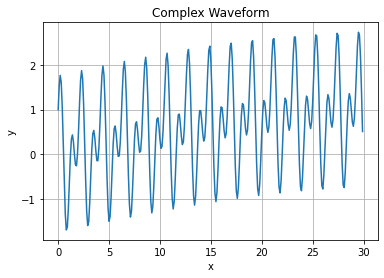

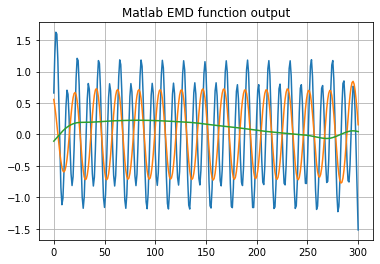

In [13]:
p = r'C:\GIT Projects\CNiBP\data\MatlabIMF.csv'
ml_imf = pd.read_csv(p,header=None) 

x = np.arange(0, 30, 0.1);
s = np.sin(0.05*x)+np.sin(6*x)+np.cos(3*x)
fs = 1/(x[1]-x[0])

plt.plot(t,s)
plt.title('Complex Waveform')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

plt.title('Matlab EMD function output')
plt.plot(ml_imf)
plt.grid()
plt.show()



(121,)
(301,)


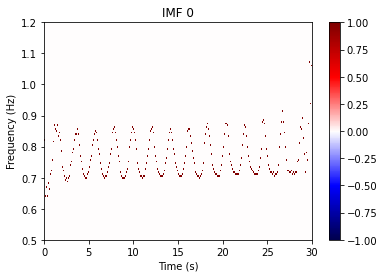

In [19]:
for n, imf in enumerate(ml_imf):
    #print(df[imf])
    T,F,P,insf,inse = hht(ml_imf[imf].values,fs,FResol= 0.01,
                          freq_min = 0.5,freq_max =1.2)
    
    scaler = MinMaxScaler()
    scaler.fit(P.toarray())
    
    #np.min(P[np.nonzero(P)]) P.max() cmap = "RdYlBu",
    cmap = plt.cm.Reds
    plt.pcolormesh(T,F, scaler.transform(P.toarray()),
                   vmin=-1,vmax=1,cmap = 'seismic' )#seismic
    plt.colorbar()
    plt.title('IMF '+str(n))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.show()
    break

In [15]:
P.shape

NameError: name 'P' is not defined

In [296]:
isinstance(0.01, (int, float))

True

In [224]:
scaler.transform(P.toarray())

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

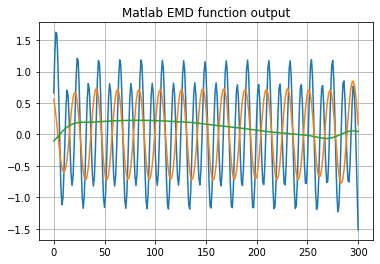

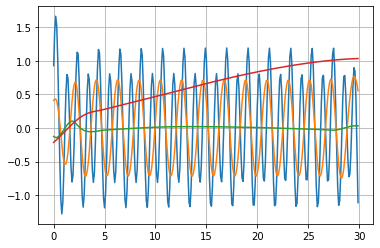

In [209]:
plt.title('Matlab EMD function output')
plt.plot(df)
plt.grid()
plt.show()

IMF = EMD(spline_kind='akima', #cubic, akima, slinear
          nbsym=1,
          extrema_detection = 'parabol').emd(s,t)

for imf in IMF:
    plt.plot(t,imf)
plt.grid()
plt.show()

#eemd = EEMD()
#eIMFs = eemd.eemd(s, t)

#for imf in eIMFs:
#    plt.plot(t,imf)
#plt.grid()
#plt.show()#

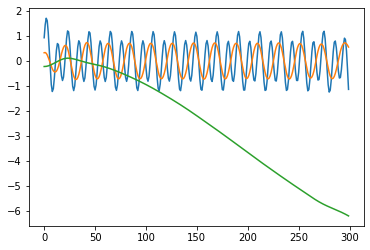

In [8]:
FRange = [0,fs/2]
FResol = (FRange[1]-FRange[0])/100
MinThres = np.NINF;

# setup frequency vector
# F = np.arange(FRange[0],FRange[1],FResol)
F = np.linspace(FRange[0], FRange[1], num=int(FRange[1]/FResol)+1)

# setup time vector
T = np.linspace(0, (1/fs)*len(y), num=int((1/fs)*len(y)/(1/fs))+1)

# Extract imfs and residue
# In case of EMD
emd = EMD()
emd.emd(y)
imfs, res = emd.get_imfs_and_residue()
N = imfs.shape[0]+2
plt.plot(pd.DataFrame(np.transpose(imfs)))